# American Community Survey Demonstration

A demonstration of how to use American Community Survey data with Metapack. 

This tutorial will demonstrate how to use Metapack with data from [Census Reporter](http://censusreporter.org) to analyze US Demographics. You will need to install at least these python packages, using pip:

```bash
pip install metapack
pip install publicdata
pip install seaborn
pip install geopandas
pip install pysal
```

# Finding Data In Census Reporter

The first step is to visit [Census Reporter](http://censusreporter.org) and find the dataset you want to work on. Census Reporter is probably the best search interface for American Community Survey data. You should explore Census Reporter a bit, and when you are ready, enter "Sex by Age" in the Explore search box. To get to the Sex and Age ducumentatino page. 

In the drop down list, select the "Sex By Age" documentation entry, then look for the link to table B01001

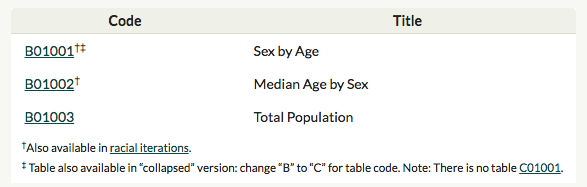

Click on that link to get to the "Table B01001: Sex By Age". In the search box at the top, search for "San Diego County". Then, in the side bar on the left, under "Divide San Diego County, CA into …" click on "Census Tracts"

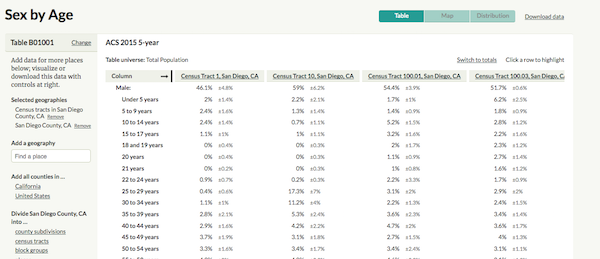

The page should shoudl data for Table B01011, and have columns for a few sensus tracts in San Diego County. Now, we need to extract three values: 

* The table name, which we already know is 'B01001'
* The Geoid for the enclosing region, San Diego County, 
* The Summary Level code for the divisions of the county, which is in this case, Tracts. 

Look at the url in the URL bar of your browser, particulary at the end of the URL. 

```
https://..../?table=B01001&geo_ids=05000US06073,140|05000US06073&primary_geo_id=05000US06073
```

The table name is after ``table=``, the value is ``B01001``. The next part of the URL, ``geo_ids=05000US06073,140``. The long string, ``05000US06073`` is the geoid of San Diego County. ( '050' is for counties, '06' is California, and '073' is San Diego County ). After the comma is the summary level of tracts, '140'.  

So, here are the important values we'll need for the next section: 

* Table: **B01001**
* Geoid: **05000US06073**
* Summary Level: **140**

Now we can get started on the rest of the notebook. First, the standard includes. Note the ``%load_ext metapack`` extension loading magic. We'll need this for some of the Metapack features. 


In [1]:

%load_ext metapack
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# Metapack

[Metapack](https://github.com/Metatab/metapack) is a data packaging system built on [Metatab](http://metatab.org). Normally, the configuration for Metapack is tored in a .csv file, but it can also be included in a Jupyter notebook. Here is what it looks like: 


In [2]:
%%metatab

Identifier: e14510ec-57b3-4fae-8c4e-c47ca7c6b55b
Name: sandiegodata.org-acs_demo-1
    
Dataset: acs_demo
Origin: sandiegodata.org
Version: 1

Section: Contacts
Wrangler: Eric Busboom
Wrangler.Email: eric@civicknowledge.com
Wrangler.Organization: Civic Knowledge

This file just establishes identity and contact information, but it also creates a new variable in the namespace, ``mt_pkg``, which you can display to see what information is being included in the package. 

In [3]:
mt_pkg

## Adding Resources

Now we can add resources to the Metatab file, so we can get a handle on the Census Reporter data. Remember the dataq we extracted from the Census Reporter web page: 

Table: B01001
Geoid: 05000US06073
Summary Level: 140

This information can be used to construct a census reporter URL that Metatab can use to get the data via the Census Reporter API. The format of the URLS are ``censusreporter:<table>/<summarylevel>/<geoid>``, so our url will be: 

```
censusreporter:B01001/140/05000US06073
```

Most of the time when you are using a lot of ACS data, all of it will be at the same level in the same geography, so you'll use cut-and-paste these urls, changing only the table name. 

Now, add this URL into the reference section of the Metatab document:


In [4]:
%%metatab
Section: Resources


Reference: censusreporter:B01001/140/05000US06073
Reference.Name: B01001
Reference.Description: Table B01001: Sex by Age

Reference: censusreportergeo://B01003/140/05000US06073
Reference.Name: tracts_cr
Reference.Description: Geo for tracts, from census reporter



Note that we also added a second resource, with the same path but a different scheme. This is a URL for the geographic boundaries of all of the tracts in San Diego County. The path also has a table in it, ``B01003``, which is the table for Total Population. That table was chosen because it's the smallest one, and we are not going to use the table information the Census Reporter includes with the geo information, but we could have also used just a geo url for table ``B01001`` and gotten the trace estimate numbers from it. 

Now, if we look at the package again, it will have the new references we added: 

In [5]:
mt_pkg

Now we can get the resource from the  data package and inspect it in Jupyter: 

In [6]:
B01001_r = mt_pkg.resource('B01001')
B01001 = B01001_r.dataframe()
B01001.iloc[:6,:6] # Show 6 rows and 6 columns

,geoid,name,B01001001,B01001001_m90,B01001002,B01001002_m90
0,14000US06073000100,"Census Tract 1, San Diego, CA",2716.0,206.0,1251.0,162.0
1,14000US06073000201,"Census Tract 2.01, San Diego, CA",2223.0,260.0,921.0,121.0
2,14000US06073000202,"Census Tract 2.02, San Diego, CA",4683.0,398.0,2323.0,253.0
3,14000US06073000300,"Census Tract 3, San Diego, CA",4875.0,417.0,2642.0,320.0
4,14000US06073000400,"Census Tract 4, San Diego, CA",3606.0,272.0,2290.0,267.0
5,14000US06073000500,"Census Tract 5, San Diego, CA",2873.0,242.0,1558.0,205.0


Note that the table we get back has a geoid for each tract ( with '140' in front to indicate Tracts, and '06073' in the middle, for San Diego County, California ) Also, there are columns with names for variables ( ``B01001001`` ) and also columns for margin-of-errors for those estimates ( ``B01001001_m90``). The Census Repoter provides a lot of features for manipulating these parts of the data frame. 


# Census Data Frames

The CensusReporter package returns, via the ``.dataframe()`` method,  a subclass of dataframes,  ``CensusDataFrame``, that has a few special methods and properties for manipulating census data. 

The core feature of these dataframes is that when you index with an array with column names, you will also get the margin columns.

There are also a few special methods that perform operations on estimates and the margins: 

* ``sum_m``. Sum several columns and their margins. 
* ``add_sum_m``. Like ``sum_m`` but also adds the summed values and margins back into the dataframe
* ``sum_col_range`` Like ``sum_m``, but takes a starting and ending column, and sums the range of columns. 
* ``add_rse`` computes the Relative Standard Error and adds a new column to the dataframe. 
* ``ratio`` Compute a ratio between two column values, also computing the margin. In a ratio, one value is not a subset of the other, such as Males to Females. A ratio can be greater than 1. 
* ``proportion`` Compute a proportion between two column values, also computing the margin. In a proportion, the numerator is a subset of the denominator, such as Males to the whole population. A proportion must be 1 or less. 

One of the first things you'll notice is that from looking at the dataframe, you have no idea what the columns are for. You can use the '.titles' property to get the dataframe with column renamed with more detailed descriptions. ( Note that this view of the table is transposed, so the column names are easier to read ) 

In [7]:
B01001.titles.head(4).T.head(10)

,0,1,2,3
geoid,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300
name,0,1,2,3
B01001001 Total,2716,2223,4683,4875
Margins for B01001001 Total,206,260,398,417
B01001002 Total Male,1251,921,2323,2642
Margins for B01001002 Total Male,162,121,253,320
B01001003 Total Male Under 5 years,53,54,115,51
Margins for B01001003 Total Male Under 5 years,39,53,84,59
B01001004 Total Male 5 to 9 years,64,56,54,0
Margins for B01001004 Total Male 5 to 9 years,43,31,42,12


If there are a lot of columns, it is often convient to search through the column titles. The ``.search_columns()`` method allows you to do that. Each of the arguments to the method can be either a string or a regular expression. 

In [8]:
import re
B01001.search_columns(' 35 ',re.compile(r'2\d years'))

,code,title
0,B01001013,B01001013 Total Male 35 to 39 years
1,B01001013_m90,Margins for B01001013 Total Male 35 to 39 years
2,B01001037,B01001037 Total Female 35 to 39 years
3,B01001037_m90,Margins for B01001037 Total Female 35 to 39 years
4,B01001008,B01001008 Total Male 20 years
5,B01001008_m90,Margins for B01001008 Total Male 20 years
6,B01001009,B01001009 Total Male 21 years
7,B01001009_m90,Margins for B01001009 Total Male 21 years
8,B01001010,B01001010 Total Male 22 to 24 years
9,B01001010_m90,Margins for B01001010 Total Male 22 to 24 years


An important feature of the ``CensusDataFrame`` is that when you index columns with an array, the dataframe will expand the array to also return the margin columns: 

In [9]:
df = B01001[['B01001001','B01001002']].copy()
df.head()

,B01001001,B01001001_m90,B01001002,B01001002_m90
0,2716.0,206.0,1251.0,162.0
1,2223.0,260.0,921.0,121.0
2,4683.0,398.0,2323.0,253.0
3,4875.0,417.0,2642.0,320.0
4,3606.0,272.0,2290.0,267.0


# Creating Summary Variables

One of the most frequent operations on Census data is to sum columns. First, we will select a subset of the columns.


In [10]:
cols = [
    'geoid',
    'B01001001', # Total Population
    'B01001002', # Total Male
    'B01001026' , # Total Female
    'B01001013','B01001014', # Males, 35-39 and 40-44
    'B01001037','B01001038' # Female, 35-39 and 40-44
]


B01001s = B01001[cols].copy()
B01001s.titles.head().T

,0,1,2,3,4
geoid,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
B01001001 Total,2716,2223,4683,4875,3606
Margins for B01001001 Total,206,260,398,417,272
B01001002 Total Male,1251,921,2323,2642,2290
Margins for B01001002 Total Male,162,121,253,320,267
B01001026 Total Female,1465,1302,2360,2233,1316
Margins for B01001026 Total Female,116,242,357,336,224
B01001013 Total Male 35 to 39 years,76,39,251,212,367
Margins for B01001013 Total Male 35 to 39 years,58,34,151,111,147
B01001014 Total Male 40 to 44 years,80,101,140,399,198


Now we can sum the male and female columns and compute some ratios. First, sum the columns. Note that the sum_m() method returns both the summed estimate, and the summed margin, which are re-assigned back in to the data frame. 

In [11]:

B01001s['male_35_44'], B01001s['male_35_44_m90'] = B01001s.sum_m('B01001013', 'B01001014')
B01001s['female_35_44'], B01001s['female_35_44_m90'] = B01001s.sum_m('B01001037', 'B01001038')
B01001s.titles.head().T

,0,1,2,3,4
geoid,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
B01001001 Total,2716,2223,4683,4875,3606
Margins for B01001001 Total,206,260,398,417,272
B01001002 Total Male,1251,921,2323,2642,2290
Margins for B01001002 Total Male,162,121,253,320,267
B01001026 Total Female,1465,1302,2360,2233,1316
Margins for B01001026 Total Female,116,242,357,336,224
B01001013 Total Male 35 to 39 years,76,39,251,212,367
Margins for B01001013 Total Male 35 to 39 years,58,34,151,111,147
B01001014 Total Male 40 to 44 years,80,101,140,399,198


Not only is the DataFrame class a special subclass, but so is the series. From an estimate columns, the ``.m90`` property returns the corresponding 90% margin column.

In [12]:
B01001s['B01001038'].m90.sum()

48990.0

The Series object also has methods for :

* 95% margin: ``.m95``
* 99% margin: ``.m99``
* Relative standard error: ``.rse``
* Standard error: ``.se``
* Summing the series: ``.sum_m90()``

In [21]:
B01001s['m_ratio'],B01001s['m_ratio_m90'] = B01001s.ratio('male_35_44','B01001002')
B01001s.add_rse('m_ratio')
B01001s['mf_proportion'],B01001s['mf_proportion_m90'] = B01001s.proportion('male_35_44','female_35_44')
B01001s.add_rse('mf_proportion');

In [14]:
B01001s.head().T

,0,1,2,3,4
geoid,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
B01001001,2716,2223,4683,4875,3606
B01001001_m90,206,260,398,417,272
B01001002,1251,921,2323,2642,2290
B01001002_m90,162,121,253,320,267
B01001026,1465,1302,2360,2233,1316
B01001026_m90,116,242,357,336,224
B01001013,76,39,251,212,367
B01001013_m90,58,34,151,111,147
B01001014,80,101,140,399,198


# Joining in geographic information

Now that we have the tract estimates that we want, its time to link them into a map. We'll use a similar method to get a dataframe for the geographic resoruce, but then use the ``.geo`` property to convert it to a GeoPandas dataframe, which has special support for geographic manipulations. Also note that we'll set the index to 'geoid', which is important for joining to our tract sex estimates table.  

In [15]:
tracts = mt_pkg.resource('tracts_cr').dataframe().geo.set_index('geoid')

The result is a GeoPandas dataframe, which has WKT geography data in the ``geometry`` columns, along with the "total population" estimates that came along with the data request. 

In [16]:
tracts.head()

,id,name,B01003001,B01003001e,geometry
geoid,,,,,
14000US06073000100,0,"Census Tract 1, San Diego, CA",2716.0,206.0,"POLYGON ((-117.194904 32.75278, -117.19471 32...."
14000US06073000201,1,"Census Tract 2.01, San Diego, CA",2223.0,260.0,"POLYGON ((-117.178867 32.75765, -117.177966 32..."
14000US06073000202,2,"Census Tract 2.02, San Diego, CA",4683.0,398.0,"POLYGON ((-117.184043 32.74571, -117.183827 32..."
14000US06073000300,3,"Census Tract 3, San Diego, CA",4875.0,417.0,"POLYGON ((-117.168645 32.748968, -117.168404 3..."
14000US06073000400,4,"Census Tract 4, San Diego, CA",3606.0,272.0,"POLYGON ((-117.170867 32.75865, -117.170187 32..."


The GeoPandas dataframe has a ``.plot`` method that will create a map of the geo data. 

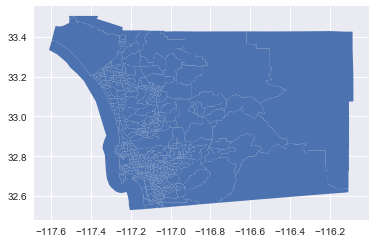

In [17]:
tracts.plot()

And, it has some features for selecting which colum from the dataframe to use to create a choroplethmap.  

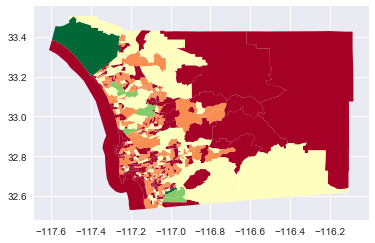

In [18]:
tracts.plot(column='B01003001', cmap='RdYlGn',scheme='fisher_jenks')

Now, we can join the previous ACS dataframe into the tracts, and plot it. 

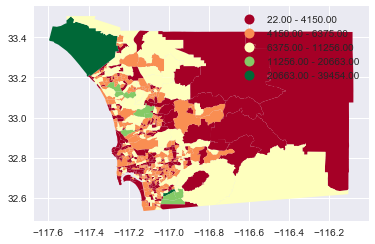

In [19]:
tracts.join(B01001s.set_index('geoid')).dropna(subset=['m_ratio']).plot(
    column='B01003001', cmap='RdYlGn',scheme='fisher_jenks', legend=True
)

That plot is a bit small, but we can explicitly define the matplotlib axis and figure, and then set the size. 

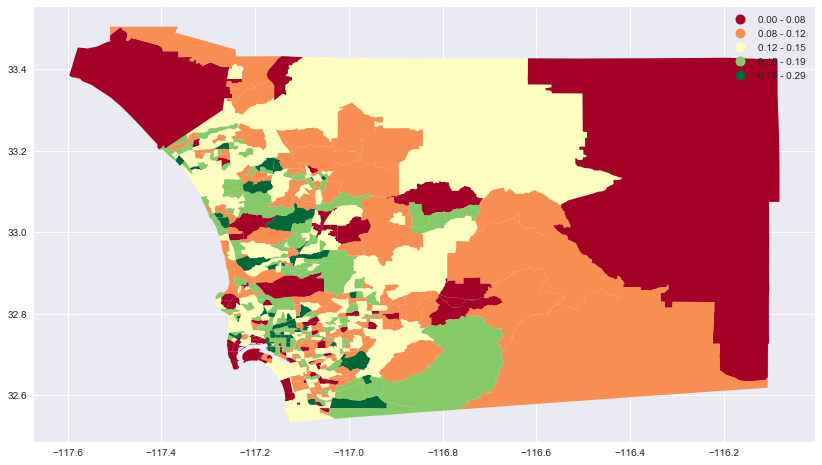

In [20]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

tracts.join(B01001s.set_index('geoid')).dropna(subset=['m_ratio']).plot(
    ax=ax, column='m_ratio', cmap='RdYlGn',scheme='fisher_jenks', legend=True
)


And that's how you analyze ACS data with Metapack. 